# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [2]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [3]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [4]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [5]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [11]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'reactions')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,2,1,6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [12]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = ['ppi-pfk','mal-snt']
for f in range(len(fluxSet)):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[fluxSet[f]] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet[f]]]
    selectedRxnDf[f].rename(columns = {fluxSet[f]:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf  

In [13]:
#Import metabolite data from excel file
Met_bound = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'metabolite_bounds')
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'KEGG_ID', 'compound','amount_int', 'Sample','Replicate','Maven filename']]
#Met_data

In [14]:
all_data={}
Uf = 1.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

for f in range(len(fluxSet)):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}

    for sm in range(12): # divide the samples into datasets
        all_data[f][sm]={}
        ditcur={}
        if sm < 6:
            smple = 'A'
        else:
            smple = 'B'
        if (sm)%3==0:
            tym = 2
        elif (sm)%3==1:
            tym = 5
        else:
            tym = 9
        if sm<3 or (sm<9 and sm>5):
            rep = 1
        else:
            rep = 2
        for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
            pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #ref_conc = {}
        for i, dat in Met_data.iterrows():
            if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep):
                #ref_conc.update({dat['KEGG_ID']: dat['amount_int']/1e6 })
                if dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00111","C00354"]: 
                    lb = dat['amount_int']/(Uf *1e6)
                    ub = dat['amount_int']/1e6 *Uf
                    if lb < DEFAULT_LB:    
                        lb = DEFAULT_LB
                    if lb > DEFAULT_UB:
                        lb = DEFAULT_UB
                    if ub < DEFAULT_LB:
                        ub = DEFAULT_LB
                    if ub > DEFAULT_UB:
                        ub = DEFAULT_UB
                    pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
        mdf_data, con = pp.conc_mdf()
        print(fluxSet[f],smple,tym,rep,mdf_data.mdf)
        ditcur['mdf']=mdf_data
        ditcur['conc']=con
        ditcur['c_bounds']={str(c.compound): (mdf_data.model.concentration_bounds.GetBoundTuple(str(c.compound))) for c in mdf_data.compound_data}
        all_data[f][sm]=ditcur


ppi-pfk A 2 1 1.0792895402859486
ppi-pfk A 5 1 0.0326391623427682
ppi-pfk A 9 1 -0.22191304527481392
ppi-pfk A 2 2 0.6908542551658172
ppi-pfk A 5 2 0.6587834176944867
ppi-pfk A 9 2 -0.2261995095895699
ppi-pfk B 2 1 0.7851330012554243
ppi-pfk B 5 1 1.1697876334268926
ppi-pfk B 9 1 1.0482164778796665
ppi-pfk B 2 2 0.5018098840897238
ppi-pfk B 5 2 0.8527626152521783
ppi-pfk B 9 2 0.7049630808297209
mal-snt A 2 1 -12.427878483002747
mal-snt A 5 1 -16.636853498543626
mal-snt A 9 1 -17.411929838901237
mal-snt A 2 2 -11.783803549127295
mal-snt A 5 2 -16.19477740884058
mal-snt A 9 2 -17.240075837110627
mal-snt B 2 1 -12.067525524004353
mal-snt B 5 1 -11.27990605961648
mal-snt B 9 1 -10.779253869857857
mal-snt B 2 2 -11.545661060548749
mal-snt B 5 2 -10.898178045017772
mal-snt B 9 2 -10.467103378960829


In [18]:
import seaborn as sns
sns.set()
fng_data={}
for f in range(2):
    fng_data[r]={}
    for r2 in range(3):
        fng_data[r][r2] = all_data[f][r2]["reaction prices"]
import pandas as pd
df = pd.DataFrame.from_dict(fng_data)
#all_data
#sns.heatmap(df)
#xlabel('PPi conc in mM')
#ylabel('timepoints')

{0: {0: {'mdf': 0.7811867453099737,
   'reaction prices': {'ATPM': 0.0,
    'CBP': 5.601242886211647e-18,
    'GLK-GTP': 5.601242886211647e-18,
    'PGMT': 0.0,
    'PGI': 1.1202485772423293e-17,
    'PFK-PPi': 0.07692307692307682,
    'FBA': 0.07692307692307687,
    'TPI': 0.07692307692307687,
    'GAPDH': 0.15384615384615374,
    'PGK-GTP': 0.15384615384615374,
    'PGM': 0.15384615384615374,
    'ENO': 0.15384615384615385,
    'PPDK': -3.3607457317269875e-17,
    'PFOR': 0.0,
    'RNF_PPiase': 0.0,
    'ALDH-NADH': 0.07692307692307687,
    'ADH-NADH': 0.07692307692307687},
   'gibbs energies': {'ATPM': -42.468800124466846,
    'CBP': -0.7811867453099737,
    'GLK-GTP': -13.267522308506027,
    'PGMT': -6.908330680362136,
    'PGI': -1.6970592173483627,
    'PFK-PPi': -0.7811867453099781,
    'FBA': -0.781186745309995,
    'TPI': -0.7811867453099701,
    'GAPDH': -0.7811867453099754,
    'PGK-GTP': -0.7811867453099772,
    'PGM': -0.7811867453099746,
    'ENO': -0.781186745309983,
  

Text(0.5, 1.0, 'MDF vs timepoints')

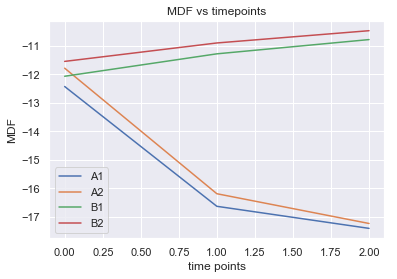

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
mdf_data={}
for k in range(2):
    mdf_data[k]={}
    for t1 in range(4):
        mdf_data[k][t1] = {}
        for t2 in range(3):
            mdf_data[k][t1][t2] = all_data[k][t1*3+t2]["mdf"].mdf
            #print(k,t1,t2,(t1*3)+(t2))
y={}
for k in range(1,2):
    for t1 in range(4):
        y[k+t1]={}
        for t2 in range(3):
            y[k+t1][t2] = float(mdf_data[k][t1][t2]) 
import pandas as pd
df = pd.DataFrame.from_dict(y)

plt.plot(df)
plt.legend(['A1','A2','B1','B2'])
plt.xlabel('time points')
plt.ylabel('MDF')
plt.title('MDF vs timepoints')

In [122]:
#for ppi-pfk, flxset=0 and for dataset B1, B2, t= 6-11
for i in all_data[0][6]["mdf"].reaction_data:
    print(i.reaction,i.shadow_price,i.dGr,i.dG0)
k=0
for c in all_data[0][6]['mdf'].compound_data:
    print(c.compound,c.concentration,c.lb,c.ub,all_data[0][6]['conc'][k])
    k=k+1


C00002 + C00001 = C00008 + C00009 0.0 -46.66772261665361 -26.392793497648427
C00009 + C00185 = C00031 + C00103 0.0 -3.2874950743687705 3.631184729342749
C00031 + C00044 = C00092 + C00035 0.0 -27.86370781510519 -14.791594269999223
C00103 = C00092 0.0 -4.905786349447643 -7.420689998837588
C00092 = C00085 1.0000000000000018 -0.7851330012554207 2.5251577008466484
C00013 + C00085 = C00009 + C00354 3.24752912019718e-17 -0.7851330012554265 -4.351421088099869
C00354 = C00111 + C00118 0.0 -0.7851330012554172 19.804143053182543
C00111 = C00118 0.0 -0.7851330012554172 5.476414708789889
C00009 + C00003 + C00118 = C00004 + C00236 0.0 -0.7851330012554172 7.779278919808803
C00035 + C00236 = C00044 + C00197 0.0 -0.7851330012554207 -20.923505855120766
C00197 = C00631 -7.444801663743472e-16 -0.7851330012554181 4.219084253619712
C00631 = C00074 + C00001 0.0 -1.5187146200594226 -4.0827201938106725
C00020 + C00013 + C00074 = C00002 + C00009 + C00022 0.0 -7.44149507757516 -19.624606603974655
C00010 + 2 C001

C00013 + C00085 = C00009 + C00354
C00013 + C00085 = C00009 + C00354
C00013 + C00085 = C00009 + C00354
C00013 + C00085 = C00009 + C00354
C00013 + C00085 = C00009 + C00354
C00013 + C00085 = C00009 + C00354


Text(0.5, 0, 'time points')

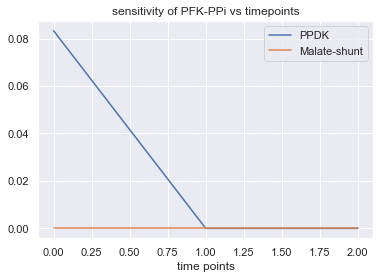

In [72]:
fng_data={}
for k in range(2):
    fng_data[k]={}
    for r in [1]:
        fng_data[k][r]={}
        for t in range(3):
            print(all_data[k][t]["mdf"].reaction_data[5].reaction)
            fng_data[k][t] = all_data[k][t]["mdf"].reaction_data[5].shadow_price
z={}
for k in range(2):
    z[k]={}
    for t in range(3):
        z[k][t] = float(fng_data[k][t]) 
import pandas as pd
df = pd.DataFrame.from_dict(z)
plt.plot(df)
plt.legend(['PPDK','Malate-shunt'])
plt.title('sensitivity of PFK-PPi vs timepoints')
plt.xlabel('time points')

In [76]:
ppi_ratio = np.linspace(14, 24, 20)
all_data_ppr={}
Uf = 1.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
f=0
for ppr in ppi_ratio:
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data_ppr[ppr] = {}

    for sm in range(12): # divide the samples into datasets
        all_data_ppr[ppr][sm]={}
        ditcur={}
        if sm < 6:
            smple = 'A'
        else:
            smple = 'B'
        if (sm)%3==0:
            tym = 2
        elif (sm)%3==1:
            tym = 5
        else:
            tym = 9
        if sm<3 or (sm<9 and sm>5):
            rep = 1
        else:
            rep = 2
        for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
            pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #ref_conc = {}
        for i, dat in Met_data.iterrows():
            if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep):
                #ref_conc.update({dat['KEGG_ID']: dat['amount_int']/1e6 })
                if dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00111","C00354"]: 
                    lb = dat['amount_int']/(Uf *1e6)
                    ub = dat['amount_int']/1e6 *Uf
                    if lb < DEFAULT_LB:    
                        lb = DEFAULT_LB
                    if lb > DEFAULT_UB:
                        lb = DEFAULT_UB
                    if ub < DEFAULT_LB:
                        ub = DEFAULT_LB
                    if ub > DEFAULT_UB:
                        ub = DEFAULT_UB
                    pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
        pp.bounds.SetBounds('C00013', 1e-3 * ppr,1e-3 * ppr )
        pp.bounds.SetBounds('C00009', 1e-3 * 10,1e-3 * 10 )
        mdf_data, con = pp.conc_mdf()
        print(ppr,smple,tym,rep,mdf_data.mdf)
        ditcur['mdf']=mdf_data
        ditcur['conc']=con
        ditcur['c_bounds']={str(c.compound): (mdf_data.model.concentration_bounds.GetBoundTuple(str(c.compound))) for c in mdf_data.compound_data}
        all_data_ppr[ppr][sm]=ditcur


14.0 A 2 1 1.0056472658702234
14.0 A 5 1 -0.05334779306750548
14.0 A 9 1 -0.27476086231139263
14.0 A 2 2 0.6908542551658101
14.0 A 5 2 0.6587834176944796
14.0 A 9 2 -0.2261995095895699
14.0 B 2 1 0.7851330012554207
14.0 B 5 1 1.0961453590111603
14.0 B 9 1 1.0482164778796559
14.0 B 2 2 0.5018098840897238
14.0 B 5 2 0.7791203408364566
14.0 B 9 2 0.7049630808297209
14.526315789473685 A 2 1 1.0132669082230557
14.526315789473685 A 5 1 -0.041918329538248145
14.526315789473685 A 9 1 -0.26333139878213174
14.526315789473685 A 2 2 0.6908542551658208
14.526315789473685 A 5 2 0.6587834176944831
14.526315789473685 A 9 2 -0.22619950958957702
14.526315789473685 B 2 1 0.7851330012554243
14.526315789473685 B 5 1 1.1037650013640068
14.526315789473685 B 9 1 1.048216477879663
14.526315789473685 B 2 2 0.5018098840897309
14.526315789473685 B 5 2 0.786739983189289
14.526315789473685 B 9 2 0.7049630808297209
15.052631578947368 A 2 1 1.0206153306186039
15.052631578947368 A 5 1 -0.030895695944934687
15.05263157

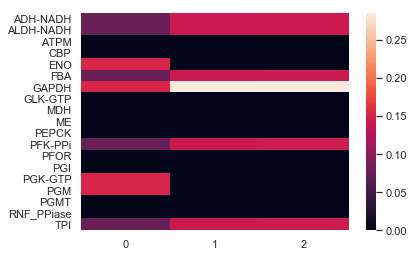

In [25]:
fng_data={}
for t in range(3):
    fng_data[t] = all_data[1][t]["reaction prices"]
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

In [ ]:
y={}
for t in range(10):
    y[t] = float(mdf_data[6][t]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('timepoints')
plt.ylabel('MDF at PPi conc of 10mM')
plt.title('MDF vs time points')